# Simulation des promotions d'un supermarché 

Auteurs : Jarod Vanderlynden , Philippe Mathieu, [CRISTAL Lab](http://www.cristal.univ-lille.fr), [SMAC team](https://www.cristal.univ-lille.fr/?rubrique27&eid=17), [Lille University](http://www.univ-lille.fr), Romain Warlop, [fifty-five](https://www.fifty-five.com/fr/)

email : jarod.vanderlynden.etu@univ-lille.fr

Création : 5/12/2022


## Introduction

Cette feuille Jupyter a pour objectif de montrer un exemple d'utilisation du modèle proposé dans l'article "Comprendre l'impact des stratégies de prix sur le comportement des consommateurs". 
Ce modèle permet notamment de construire un outil de simulation reproduisant des faits marketings connus.
Ce notebook détaille ce modèle et en présente les résultats principaux.

Dans ce modèle on représente un supermarché dans lequel on vend des biens de consommation courante. Les agents sont des entités (une personne, une famille etc.) représentant les clients, ayant chacun des paramètres internes uniques. 

Ce modèle ne prend pas en compte la géographie du magasin ni l'emplacement des produits. 



In [2]:
from src.model import *

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import copy
import time
sns.set_theme()
from IPython.display import set_matplotlib_formats

### Les produits
Les produits sont des biens de consommation simple, disposant de 4 caractéristiques : un prix, une qualité, une quantité, et un booléen de promotion. On leur ajoute un nom afin de pouvoir les appeler plus simplement. la notion de produit est à comprendre au sens large : un singleton ou éventuellement un lot.

Ils sont instanciés via la classe `Product(Nom,Prix,Qualité,Quantité)`. Le prix est un prix unitaire, la qualité un réel entre 0 et 1 et la quantité le nombre d'unités présentes dans le paquet. La quantité de produit fait référence au nombre de produits unitaires dans un pack. Pour des raisons de simplicité, nous ne modélisons pas le volume d'un produit (en gramme, en ml, etc.). Ce modèle se focalise sur les promotions et donc s'interesse principalement à la notion de lots.


In [3]:
p0 = Product("Pâtes de marque X",2.3,0.5,2)

Le produit `p0` ici créé possède un prix unitaire de `2.3`, mais aussi un prix global pour l'ensemble.

In [4]:
p0.get_price_unit(),p0.get_price_total()

(2.3, 4.6)

Pour plus de réalisme les produits sont répartis en différentes catégories. Une catégorie représente un groupe de produits comparables entre eux. Dans ce modèle un client ne choisira qu'un seul article dans une catégorie donnée.

Une catégorie de produit est instancié avec `ProductsCategorie(nom,liste des produits)`. La création d'une catégorie nécéssite une liste de produits. La liste de produits peut être initialement vide, on ajoutera alors les produits après au fur et à mesure grace à la méthode `add_product(produit)`. 

In [5]:
cat = ProductsCategorie("test",[p0])
cat.show_products()

Nom :  Pâtes de marque X , Prix total :  4.6


0

In [6]:
P1 = Product("Pâtes de marque Y",1.6,0.4,4)
cat.add_product(P1)
cat.show_products()

Nom :  Pâtes de marque Y , Prix total :  6.4
Nom :  Pâtes de marque X , Prix total :  4.6


0

- Un produit est donc caratérisé par 4 attributs et donne accès à plusierus méthodes dont ``get_name(),get_price_total(),simple_promotion(percent)``, percent est le pourcentage de réduction à appliquer au produit.
- Une catégorie est uniquement caractérisée par son nom et les produits qu'elle contient. Elle donne accès à plusieurs méthodes dont ``add_product(product), get_products(), show_products()``

### L'environnement

L'environnement correspond au supermarché. On ne s'interesse pas dans ce modèle au placement des produits, il est donc constitué uniquement de la liste de sproduits qu'il contient. Afin de l'instancier on lui fournit une liste de catégories qui elles-mêmes contiennent les produits. 
Un magasin plus complet devrait contenir plusieurs catégories contenant plusieurs produits. Dans cet exemple une seul catégorie nous suffit pour illustrer les résulats. 
Le environnement est instancié avec `SMA(list_cat[cat1,cat2,...],nb_agent,nb_ticks)` list_cat étant une liste de catégorie de produits, nb_agent le nombre d'agents, et nb_ticks le nombre de pas de temps de simulation.

Dans ce modèle, nous partons du principe que les produits sont disponibles en quantité infinie. Il n'y a donc pas de quantité en stock ni de rupture de stock. 

Le paramètre "nb_agents" génère `n` agents dont les caractéristiques sont aléatoires (besoins, sensibilités etc ...).

On crée tout d'abord un environnement sans agent. 

In [7]:
mon_environnement = SMA([cat],0,10)

L'environnement dispose de quelque paramètre à initialiser, nous reviendrons sur l'impact de certains d'entre eux après pour le moment nous les initialisons à une valeur prédéfinie lors de l'initialisation.

In [8]:
mon_environnement.initialise()

0

Pour l'instant il n'y a pas d'agent. Si on lance une simulation maintenant, rien ne se passe.
L'attribut `revenus` permet d'obtenir le chiffre d'affaire obtenu à chaque pas de temps de simulation.
Nous avons indiqué précédemment notre souhait d'avoir 10 tours de parole, si on execute le SMA, on obtient alors une 10 valeurs, pour l'instant toutes à zero puisqu'il n'y a personne.

In [9]:
mon_environnement.run()
mon_environnement.get_turnover()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Les agents

Les agents représentent les clients. Un client est défini comme une entité qui représente généralement une famille (un panier de courses) capable de faire des choix sur les produits dont il a besoin pour pour son processus d'achat. 
Un agent est instancié avec la méthode `Agent(nom, env, H, profil)`. env est l'environnement, H est l'historique de l'agent, p est le profil de l'agent. H et p sont optionnels.

In [10]:
mon_premier_agent = Agent("Mon 1er agent",mon_environnement)

Cet agent dispose d'un historique d'achats et d'un profil tirés aléatoirement. 
#### Les profils / sensibilités
Les profils pouvant être tirés sont les suivants : "Prix, Qualité, Promophile, Intertiel, Equilibré". Un profil de type "Prix" accorde beaucoup d'importance aux prix des produits, c'est l'équivalent d'un agent a petit budget. A l'invere un agent de type "Qualité" est un agent qui accorde beaucoup d'importance à la qualité, c'est l'équivalent d'un agent qui dispose d'un gros budget et est prêt à essayer des nouveaux produits si ceux-ci sont de bonne qualité. Ces profils suivent la même idée pour le profil "Promohpile", et "Inertiel" le profil equilibré accorde une importance a peu près similaire a tous ces attributs. Les profils déterminent les sensibilités les "Beta_p,Beta_q,Beta_i,Beta_d" qui sont les paramètres qui modulent comment les agents évaluent les produits et par conséquence ce que les agents choisissent comme produits.

In [11]:
mon_premier_agent.get_sensibility()

{'inertie': array([0.19817273]),
 'price': array([0.25048081]),
 'quality': array([0.24773986]),
 'promophile': array([0.3036066])}

On remarque que cet agent est un agent type "Prix" car sa sansibilité au prix est plus élevée que les autres.

Pour créer un profile personalisé il faut utiliser : Profile(liste des sensibilités) 
##### la liste des sensibilités est dans cet ordre: "Prix, Qualité, Inertie, Promopilie"
Au plus la valeur est élevée par rapport aux autre valeurs au plus l'agent accorde d'importance à ce paramètre. (Les valeurs passés sont normalisés de façon à ce que la somme fasse 1.)

In [12]:
mon_profil = Profile([100,10,6,100])
mon_profil.get_profile()

{'inertie': 0.027777777777777776,
 'price': 0.46296296296296297,
 'quality': 0.046296296296296294,
 'promophile': 0.46296296296296297}

Il suffit maintenant de passer ce profile à la création d'un nouvel agent. 

In [13]:
mon_agent_personalisé = Agent("Agent 2",mon_environnement,profile=mon_profil.get_profile())

### L'historique

L'historique représente les derniers achats d'un agent par catégorie. Cet historique est un dictionnaire dont la clé est le nom de la catégorie et les valeurs la liste des produits achetés par cet agent. de produit de l'environnement en type (quel produit) et en quantité (le nombre du produit acheté).
Voici un aperçu de l'historique généré aléatoirement des agents que nous avons crées. Les clés sont les différentes catégories.

In [14]:
mon_premier_agent.get_history()

{'test': [(Pâtes de marque X, 9),
  (Pâtes de marque Y, 8),
  (Pâtes de marque X, 5),
  (Pâtes de marque Y, 9),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 3),
  (Pâtes de marque Y, 8),
  (Pâtes de marque X, 7),
  (Pâtes de marque Y, 6),
  (Pâtes de marque Y, 11),
  (Pâtes de marque Y, 4),
  (Pâtes de marque X, 6),
  (Pâtes de marque X, 4),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 4),
  (Pâtes de marque Y, 7),
  (Pâtes de marque Y, 6),
  (Pâtes de marque Y, 4),
  (Pâtes de marque Y, 7),
  (Pâtes de marque X, 7),
  (Pâtes de marque Y, 5),
  (Pâtes de marque Y, 10),
  (Pâtes de marque Y, 7),
  (Pâtes de marque Y, 3),
  (Pâtes de marque X, 7),
  (Pâtes de marque Y, 10),
  (Pâtes de marque X, 11),
  (Pâtes de marque Y, 3),
  (Pâtes de marque Y, 5),
  (Pâtes de marque Y, 10),
  (Pâtes de marque X, 3),
  (Pâtes de marque Y, 11),
  (Pâtes de marque X, 8),
  (Pâtes de marque Y, 11),
  (Pâtes de marque X, 9),
  (Pâtes de marque Y, 7),
  (Pâtes de marque X,

Pour réaliser un historique il y a 2 méthodes, `History_gen(cat_list, Lambdas_list)` et `History (dict{catégorie1:achats,...},dict{catégorie1:quantité,....})`. La première méthode génère un historique a partir de la liste des catégories et des lambda associé. La seconde nécéssite un historique complet. 

In [15]:
H = History_gen([cat],10)

In [16]:
mon_second_agent_personalisé = Agent("Agent 3",mon_environnement,profile=mon_profil.get_profile(),history = H)

Ajoutons ces 3 agents à notre environnement. Attention a bien passer une liste en paramètre.

In [17]:
mon_environnement.add_agent([mon_premier_agent,mon_agent_personalisé,mon_second_agent_personalisé])

## La simulation

Maintenant nous disposons de tout ce dont nous avons besoin pour réaliser une simulation. La simulation peut être lancée plusieurs fois, un résultat différent devrait apparaître. Cela est du a l'aléatoire du modèle notamment dans le choix des agents, l'agent choisi un produit d'une catégorie selon une loi de probabilité propotionnel au score du produit. 

In [18]:
mon_environnement.initialise()
mon_environnement.run()
mon_environnement.get_turnover()

array([ 82.8,  46.8,  15.6,  60.6,  31.2,  64.4, 119.6,  15.6,  46. ,
        50.6])

Voici le chiffre d'affaires à chaque pas de temps qui correspond à : pour tous les agents (produits achetés * quantité acheté * prix).
Pour mieux comprendre les mécanismes du modèle on affiche une trace de ce que les agents ont acheté.

In [19]:
mon_environnement.initialise()
mon_environnement.run(trace=True)
mon_environnement.get_turnover()

Pas de temps num :  0  Agent :  Mon 1er agent  Besoin 6.46  Achat : Rien Quantité : 0
Pas de temps num :  0  Agent :  Agent 2  Besoin 7.8  Achat : Rien Quantité : 0
Pas de temps num :  0  Agent :  Agent 3  Besoin 11.06  Achat :  Pâtes de marque X Quantité :  15
Pas de temps num :  1  Agent :  Mon 1er agent  Besoin 6.62  Achat :  Pâtes de marque X Quantité :  6
Pas de temps num :  1  Agent :  Agent 2  Besoin 7.94  Achat :  Pâtes de marque X Quantité :  9
Pas de temps num :  1  Agent :  Agent 3  Besoin 10.8  Achat : Rien Quantité : 0
Pas de temps num :  2  Agent :  Mon 1er agent  Besoin 6.62  Achat :  Pâtes de marque X Quantité :  3
Pas de temps num :  2  Agent :  Agent 2  Besoin 7.9  Achat :  Pâtes de marque Y Quantité :  2
Pas de temps num :  2  Agent :  Agent 3  Besoin 10.9  Achat :  Pâtes de marque X Quantité :  9
Pas de temps num :  3  Agent :  Mon 1er agent  Besoin 6.62  Achat :  Pâtes de marque X Quantité :  2
Pas de temps num :  3  Agent :  Agent 2  Besoin 7.72  Achat :  Pâtes de

array([ 69. ,  69. ,  68. ,  13.8,  46. , 101.2,  82.8,  41.4,   9.2,
        23. ])

Nous allons générer un environnement plus dense (avec plus d'agents et de produits). Nous resterons sur des simulations avec une seul catégorie de produit car les catégories de produits ne s'influencent pas entre-elles.

Créons d'abord une catégorie de produit contenant 9 produits. Nous avons choisi de faire 9 produits assez similaire notamment sur le ratio qualité/prix pour éviter l'apparition d'un "super produit", de meilleur qualité et moins cher que les autres, que tous les agents achèteraient. Il est tout à fait possible de créer cette catégorie à la main ou de tout autre manière.

In [20]:
base_price = np.random.randint(10, 100)
products = []
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   # On tire un prix de base aléatoire
    quality = np.random.normal((price/100),0.1)               # On tire une qualité proportionelle au prix
    for i in range(3):                                        # Création de 3 produits qu'on considerera d'une même marque (même qualité)
        products.append(Product(("Produit " + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9                                   # On estime que le prix à l'unité est plus bas sur les produits vendu en grand quantité
Ma_categorie = ProductsCategorie("Ma_categorie", products)

Création de l'environnement

In [21]:
environnement_test = SMA([Ma_categorie],300,100)

In [22]:
environnement_test.initialise()

0

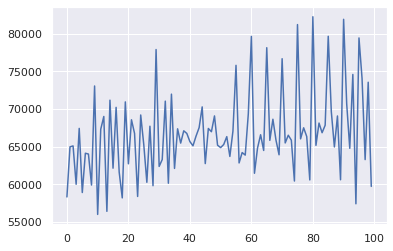

In [23]:
environnement_test.run()
plt.plot(environnement_test.get_turnover())

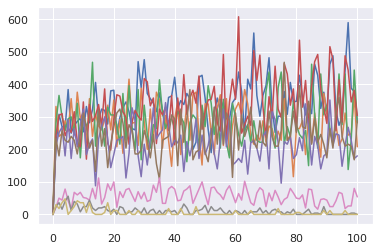

0

In [24]:
environnement_test.show_sales()

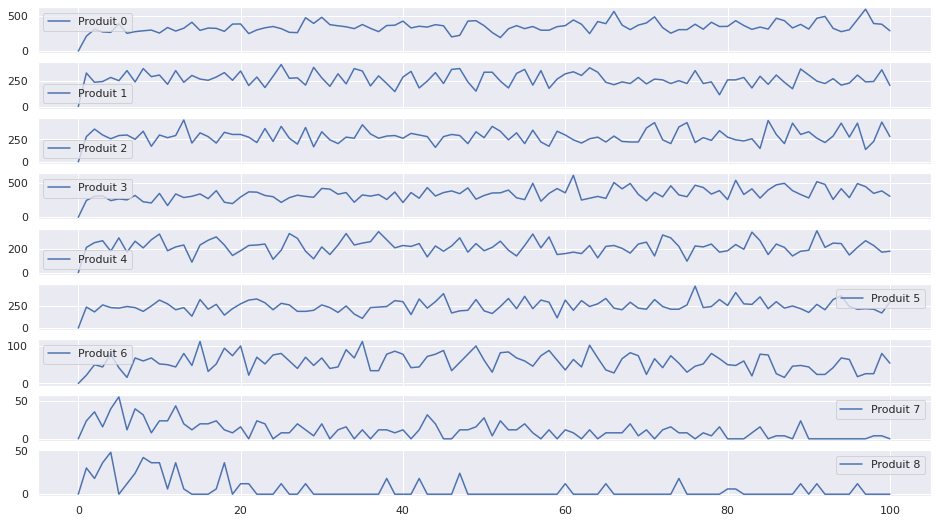

0

In [25]:
environnement_test.show_sales_separated()

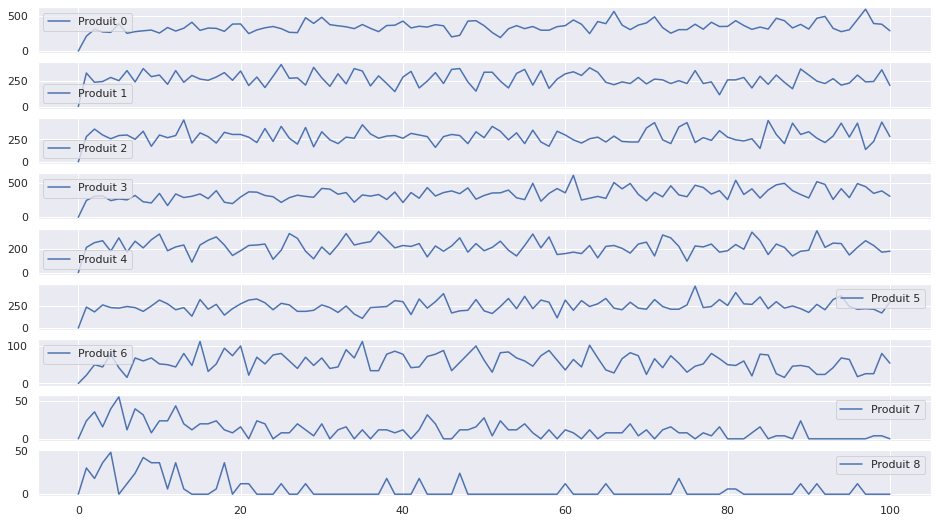

0

In [26]:
environnement_test.show_sales_separated()

## La promotion
L'environnement dispose de toutes les informations nécéssaires, nous allons pouvoir appliquer différentes promotions à notre modèle via la méthode `make_promo(type,quantity,ticks,category,product)`.

`type` est le type de promotion. (0 de type pourcentage de réduction, 1 de type x acheté y offert)

`quantity` le pourentage de la promotion (si c'est une promotion en %) ou un tuple (x,y) si c'est une promotion x acheté y offert.

`ticks` un tuple contenant le pas de temps du début de la prodmotion et le pas de temps de fin de promotion. 

`category` l'indice de a categorie sur laquel faire la promotion.

`product` l'indice du produit sur lequel faire la promotion. 

Par exemple `make_promo(0,40,(30,34),0,0)` : 0 pour une promotion en pourcentage, 40 pour 40% (30 pas de temps de départ, 34, pas de temps d'arrêt) et 0,0 pour la catégorie d'indice 0 et le produit d'indice 0

In [27]:
environnement_test.initialise()
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()

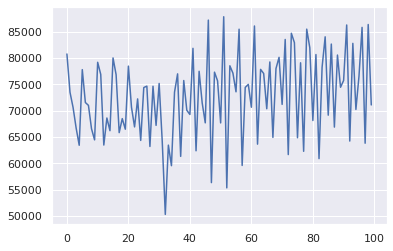

In [28]:
plt.plot(environnement_test.revenues)

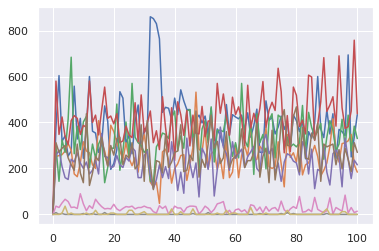

0

In [29]:
environnement_test.show_sales()

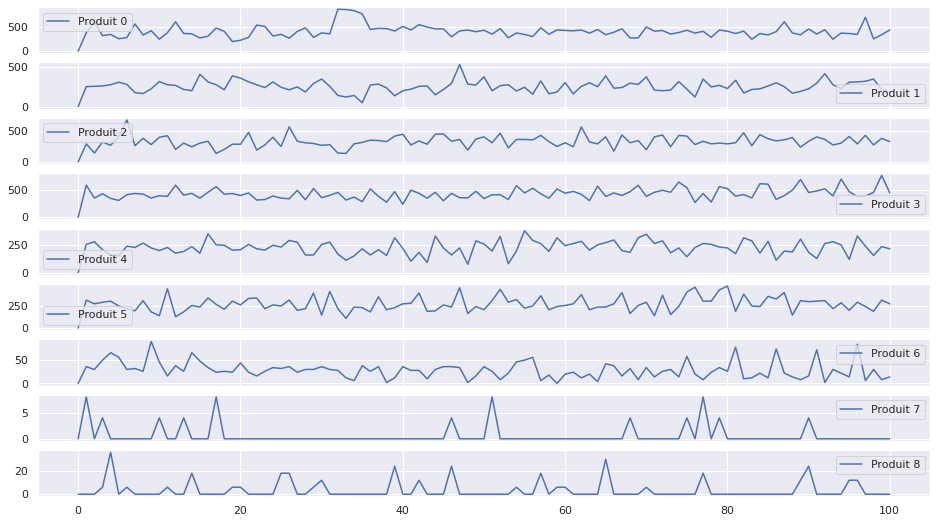

0

In [30]:
environnement_test.show_sales_separated()

On observe sur cette simulation que le produit 0, qui est le produit en promotion, voit une forte augmentation de ses ventes durant la promotion. 
Afin de pouvoir observer l'impact des promotions plus préciséments nous allons comparer une même simulation avec et sans promotion. 

Afin d'avoir les mêmes agents dans chaque simulation pour la comparaison nous proposons de fixer la graine aléatoire. 

In [33]:
np.random.seed(3)
base_price = np.random.randint(10, 100)
products = []
#Création des produits selon la même méthode que précédemment.
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   
    quality = np.random.normal((price/100),0.1)               
    for i in range(3):                                      
        products.append(Product(("Produit " + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9  
Ma_categorie = ProductsCategorie("Ma_categorie", products)

In [34]:
np.random.seed(3)
environnement_promo = SMA([Ma_categorie],300,100)
np.random.seed(3)
environnement_sans_promo = SMA([Ma_categorie],300,100)

In [37]:
environnement_promo.initialise()
environnement_promo.make_promo((0,40,(30,34),0,0))
environnement_sans_promo.initialise()

0

In [38]:
environnement_promo.run()
environnement_sans_promo.run()

Si on veut, il est possible d'afficher les résultats sur une même figure de cette manière :

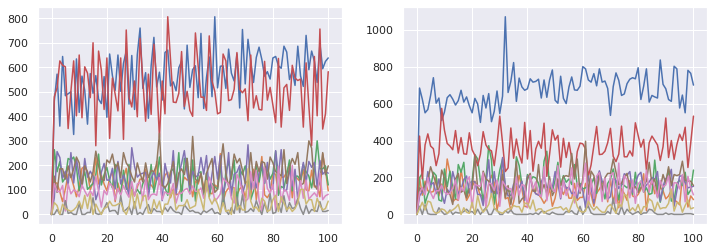

In [39]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(environnement_sans_promo.get_sales())
axs[1].plot(environnement_promo.get_sales())

On peut observer le pic des ventes du produit 0 (en bleu) au moment de la promotion ainsi qu'une certaine fidélisation. 

## Un test plus simple pour la guerre des prix

On génère 2 produits assez similaires, un porté sur la qualité, l'autre sur le prix. On peut aussi imaginer deux produits très différents en terme de prix/qualité ou encore 2 produits encore plus similaires. Ces caratéristiques auront un impact sur les courbes que nous allons observer. Le but ici est de présenter une guerre des prix, avec des baisses successives du prix des produits. 

Dans un premier temps la méthode SMA.get_favorites() permet de récupérer pour chaque produit le nombre d'agent ayant pour favorit le produit. Un agent a pour produit favori celui qu'il le plus acheté dans l'historique de l'agent. Voici comment utiliser get_favorites():

In [43]:
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 10, 0.5, 1), Product("Produit_B", 12, 0.7, 1)])
envrionnement_price_war = SMA([cat_0],300,10)
envrionnement_price_war.initialise()
envrionnement_price_war.run()
#On récupère les informations
results = envrionnement_price_war.get_favorites()
results

{'Produit_A': [130, 130, 121, 117, 112, 111, 112, 108, 103, 97],
 'Produit_B': [170, 170, 179, 183, 188, 189, 188, 192, 197, 203]}

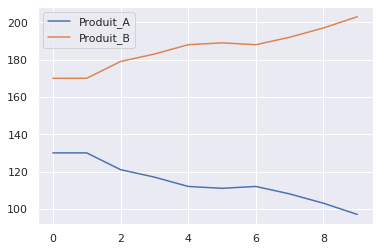

In [44]:
plt.plot(results['Produit_A'],label='Produit_A')
plt.plot(results['Produit_B'],label='Produit_B')
plt.legend()

On observe que le produit B est légèrement meilleur que le produit A sur notre population d'agents. 

On relance une simulation avec des produits différents pour illustrer le fait qu'avec seulement 2 produits en concurence direct leurs paramètres ont une grand importance. 

De plus la prise en compte des paramètres globaux peuvent faire varier l'importance du prix ou de la qualité. 

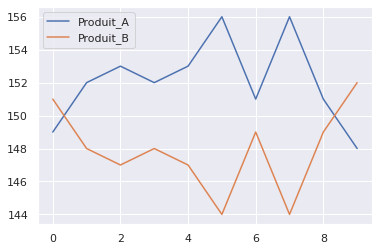

In [46]:
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 6, 0.6, 1), Product("Produit_B", 24, 0.7, 1)])
envrionnement_price_war = SMA([cat_0],300,10)
envrionnement_price_war.initialise()
envrionnement_price_war.run()
#On récupère les informations
results = envrionnement_price_war.get_favorites()
results
for k in results.keys():
    plt.plot(results[k],label=k)
plt.legend()

Nous allons réaliser des simulations de 100 pas de temps à graine aléatoire fixé (pour la comparaison)

Maintenant nous allons réaliser une simulation un peu plus longue sans changement de prix.

In [47]:
np.random.seed(42)
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 100, 0.5, 1), Product("Produit_B", 120, 0.6, 1)])
envrionnement_price_war = SMA([cat_0],300,100)
envrionnement_price_war.initialise()
envrionnement_price_war.run()
#On récupère les informations
chiffreAffaires = envrionnement_price_war.revenues
favoris = envrionnement_price_war.get_favorites()

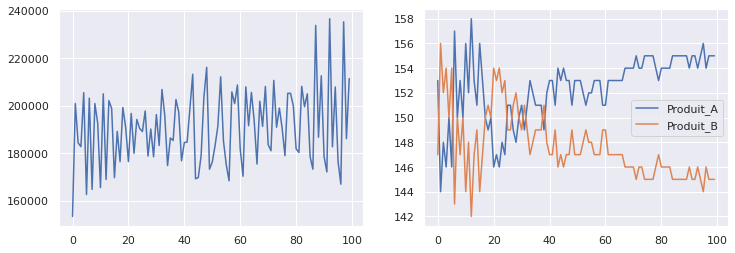

In [48]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Nouvelle simulation avec une baisse du prix uniquement du produit A

Un changement de prix définitif, qui n'est pas une promotion, s'effectue avec la méthode `reduce_price(pourcentage, tick d'effet, produit)` ou `raise_price(pourcentage, tick d'effet, produit)`. ce qui donne par exemple `reduce_price(20, 30, 0, 0)`.

In [50]:
np.random.seed(42)
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 100, 0.5, 1), Product("Produit_B", 120, 0.6, 1)])
envrionnement_price_war = SMA([cat_0],300,100)
envrionnement_price_war.initialise()
#On indique à quel moment à lieu la baisse de prix ()
envrionnement_price_war.reduce_price(40, 30, 0, 0)
envrionnement_price_war.run()
#On récupère les informations
chiffreAffaires = envrionnement_price_war.revenues
favoris = envrionnement_price_war.get_favorites()

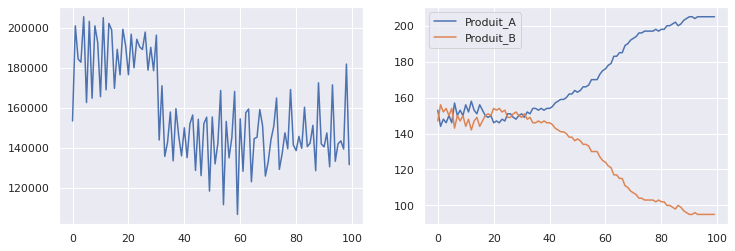

In [51]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Finalement on réalise une simulation avec ce qu'on entend par guerre des prix, c'est à dire, le prix du produit B baisse ce qui entraine une baisse du prix du produit A ce qui entraine une baisse du produit B etc. 

In [52]:
np.random.seed(42)
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 100, 0.5, 1), Product("Produit_B", 120, 0.6, 1)])
envrionnement_price_war = SMA([cat_0],300,100)
envrionnement_price_war.initialise()
#On indique à quel moment à lieu la baisse de prix ()
envrionnement_price_war.reduce_price(20, 10, 0, 0)
envrionnement_price_war.reduce_price(20, 20, 0, 1)
envrionnement_price_war.reduce_price(20, 30, 0, 0)
envrionnement_price_war.reduce_price(20, 40, 0, 1)
# envrionnement_price_war.reduce_price(20, 50, 0, 1)
# envrionnement_price_war.reduce_price(20, 60, 0, 1)
envrionnement_price_war.run()
#On récupère les informations
chiffreAffaires = envrionnement_price_war.revenues
favoris = envrionnement_price_war.get_favorites()

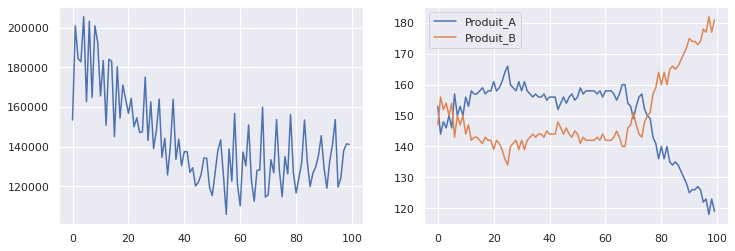

In [53]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

## Les paramètres du modèle
Le modèle dispose de 7 paramètres : prix, qualité, promophile, sat_alpha, phi, c, inertie. 
Prix qualité promophile et inertie sont des paramètres que gèrent l'importance global pour les agents du prix de la qualité de la promotion et de l'inertie.

Un prix à 1 avec les autres valeurs à 0 signifierais que les agents prennent tous uniquement en compte le prix des produits pour déterminer leurs achats.

sat_alpha correspond au paramètre de régulation de la pente de la fonction de saturation (utilisé dans le calcul de la quantité). Plus il est élevé plus la pente est douce et inverssement. C est la borne supérieur de cette fonction de saturation.

Finalement Phi correspond a l'intensité de l'aversion à a perte. Phi = 0.5 équivaut à ce que perdre 1€ impact négativement un agent 1.5 fois plus que de gagner 1€ l'impact positivement. Phi = 2 correspondrait a ce même ratio égal à 3.

Jusqu'a maintenant les paramètres étaient initialisé a ces valeurs : price=0.5, quality=100, promophile=5, sat_alpha=100, phi=0.3, c = 2, inertia = 2 choisies arbitrairement. 

Les 4 paramètres globaux prix qualité promotion et inertie sont multipliés par les valeurs des produits lors des évaluations. Ainsi ces paramètres globaux régulent l'importance de chaque effet.

Par exemple le prix étant dans nos exemples ci-dessus était environ égal à 100, la qualité comprise en entre 0 et 1 la promotion égal soit à 0 soit 1 et l'inertie ayant une valeur compris entre -4 et 20. 

Ces valeurs multipliées par nos paramètres globaux on obtiens (50, [0,100], (0 ou 5), [-8,40]). Ce sont des valeurs plus proches les unes des autres, nos paramètres globaux viennent donc bien équilibrer l'impact du prix de la qualité de la promotion et de l'inertie. Il permettent aussi de jouer sur le comportement de tous les agents afin d'exacerber certains comportements.

#### C et alpha_sat
Pour mieux comprendre les valeurs alpha_sat et c on affiche la fonction de saturation en faisant varier ces valeurs.

In [54]:
def sat(U,alpha,c):
        x = (U)
        y = math.log(c-1)
        return c / (1 + math.exp(-x/alpha+y))

Text(0, 0.5, 'Multiplicateur de quantité')

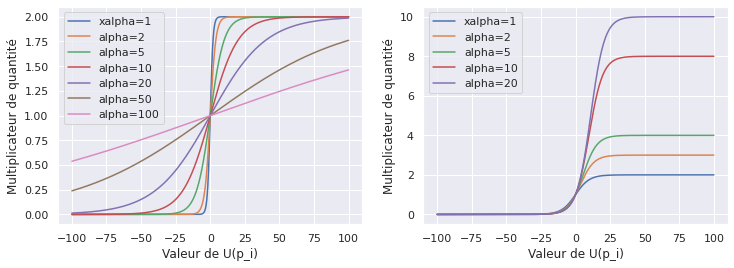

In [55]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
for alpha in [1,2,5,10,20,50,100]:
    c=2
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[0].plot(np.arange(-100,100,0.01),res)
axs[0].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[0].set_xlabel("Valeur de U(p_i)")
axs[0].set_ylabel("Multiplicateur de quantité")
for c in [2,3,4,8,10]:
    alpha = 5
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[1].plot(np.arange(-100,100,0.01),res)
axs[1].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[1].set_xlabel("Valeur de U(p_i)")
axs[1].set_ylabel("Multiplicateur de quantité")

#### Simulations pour différents paramètres

Voici quelque exemples de changements de paramètres. On reprend la catégorie de produit à 8 produits utilisée précedemment. 

In [56]:
environnement_test = SMA([Ma_categorie],300,100)

Les paramètres de l'evironnement sont passés via la méthode initialise() 
Les paramètres sont price, quality, promophile, sat_alpha, phi, c, inertia

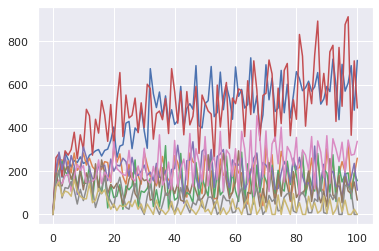

0

In [57]:
environnement_test.initialise(inertia = 10)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

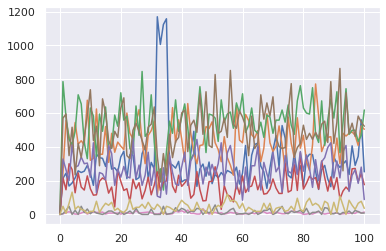

0

In [58]:
environnement_test.initialise(inertia = 0)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

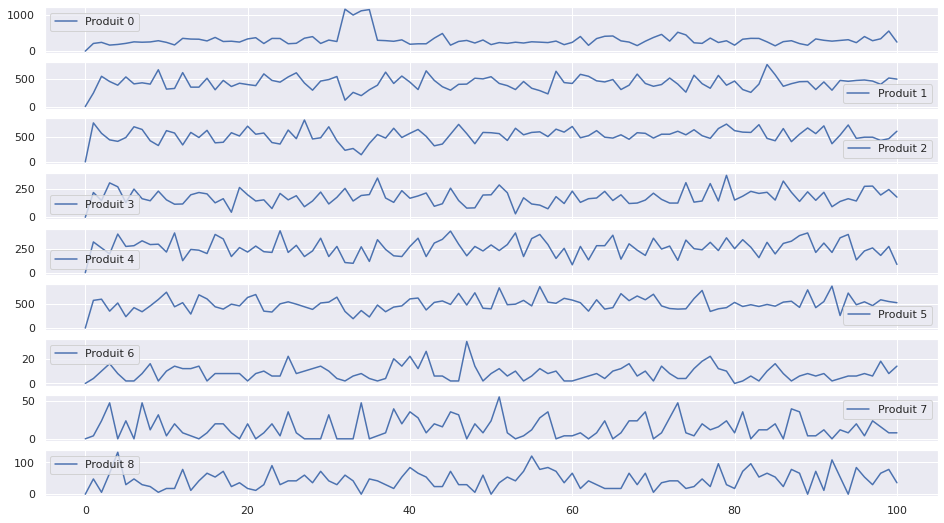

0

In [59]:
environnement_test.show_sales_separated()

On vois qu'il n'y a plus de fidélisation

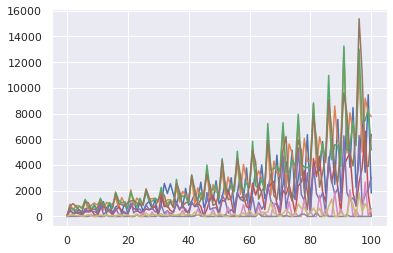

0

In [60]:
environnement_test.initialise(price=0.5, quality=100, promophile=5, sat_alpha=1, phi=0.3, c = 2, inertia = 2)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

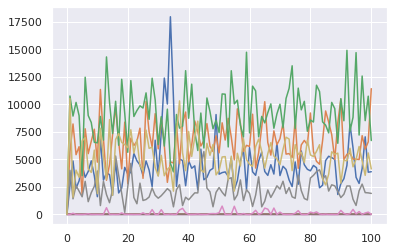

0

In [61]:
environnement_test.initialise(price=2, quality=0, promophile=5, sat_alpha=100, phi=0.3, c = 2, inertia = 0)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

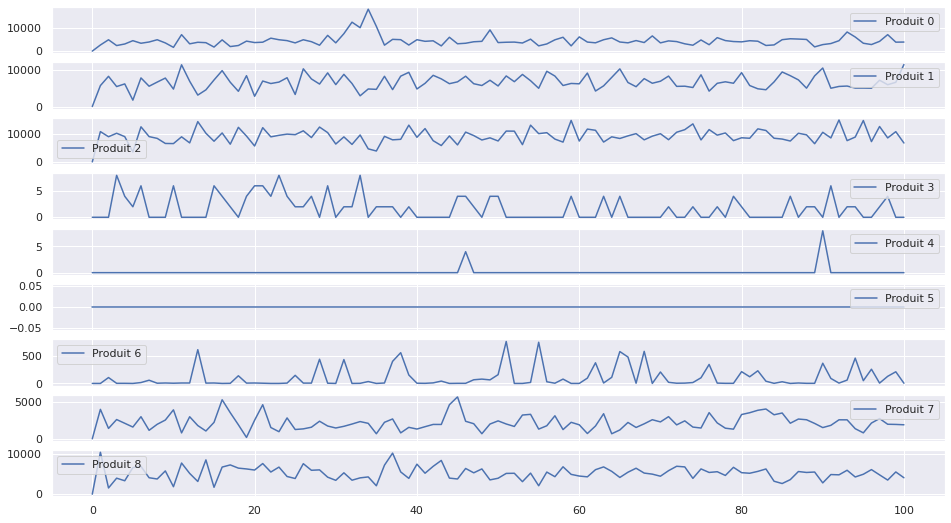

0

In [62]:
environnement_test.show_sales_separated()

La qualité n'ayant plus d'impact on observe que certains produits (les plus cher) ne sont plus du tout achetés 